SurfaceMesh object with batching strategy Batching.NONE
            vertices: [8, 3] (torch.float32)[cuda:0]  
               faces: [12, 3] (torch.int64)[cuda:0]  
             normals: [6, 3] (torch.float32)[cuda:0]  
    face_normals_idx: [12, 3] (torch.int64)[cuda:0]  
                 uvs: [14, 2] (torch.float32)[cuda:0]  
        face_uvs_idx: [12, 3] (torch.int64)[cuda:0]  
material_assignments: [12] (torch.int16)[cuda:0]  
           materials: list of length 0
       face_vertices: if possible, computed on access from: (faces, vertices)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertex_normals, faces) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, comput

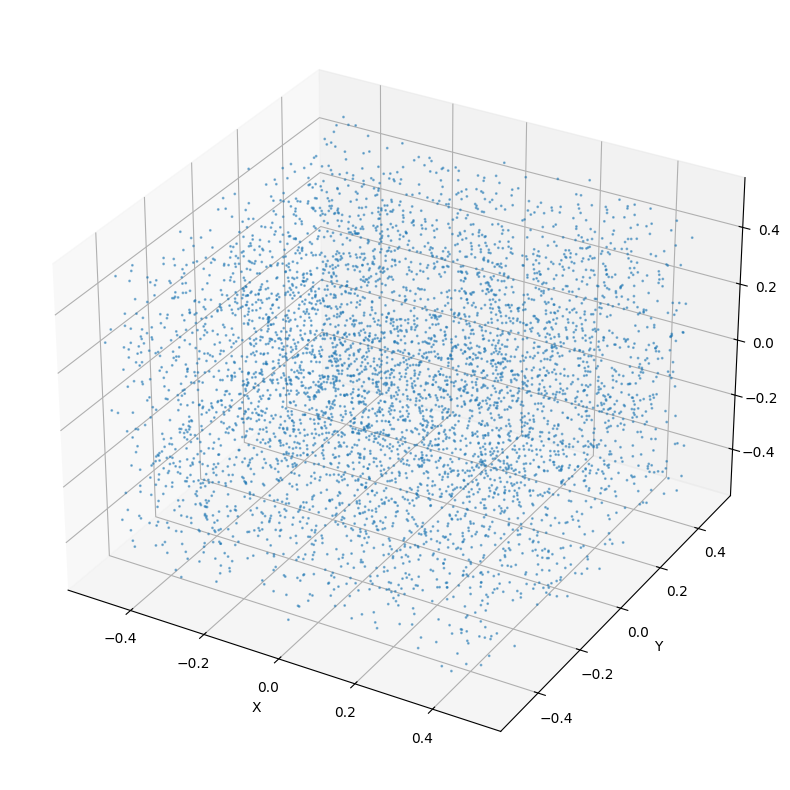

Saved visualization to interior_points.png


In [2]:
# https://github.com/NVIDIAGameWorks/kaolin/blob/master/examples/tutorial/physics/simplicits_easy_api.ipynb
import os
os.environ["KAOLIN_NO_WIDGETS"] = "1"

import numpy as np
import torch
import kaolin as kal

from py.utils import *

asset_folder = find_file_or_folder('assets', os.getcwd())

mesh = kal.io.import_mesh(str(asset_folder / 'cube.obj'), triangulate=True).cuda()
mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices.unsqueeze(0), normalize=True).squeeze(0) 
orig_vertices = mesh.vertices.clone()
print(mesh)

# Physics material parameters
soft_youngs_modulus = 1e5
poisson_ratio = 0.45
rho = 500.0
approx_volume = 0.5

# Sample points in bounding box
num_samples = 1000000
uniform_pts = torch.rand(num_samples, 3, device='cuda') * (
    orig_vertices.max(dim=0).values - orig_vertices.min(dim=0).values
) + orig_vertices.min(dim=0).values

boolean_signs = kal.ops.mesh.check_sign(
    mesh.vertices.unsqueeze(0), 
    mesh.faces, 
    uniform_pts.unsqueeze(0), 
    hash_resolution=512
)

# Points inside the mesh
pts = uniform_pts[boolean_signs.squeeze()]
print(f"Points inside mesh: {pts.shape[0]}")

yms = torch.full((pts.shape[0],), soft_youngs_modulus, device="cuda")
prs = torch.full((pts.shape[0],), poisson_ratio, device="cuda")
rhos = torch.full((pts.shape[0],), rho, device="cuda")

# Save points to file instead of k3d visualization
np.save("interior_points.npy", pts.cpu().numpy())
print(f"Saved {pts.shape[0]} points to interior_points.npy")

# Or visualize with matplotlib (static)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Subsample for visualization
vis_pts = pts[::max(1, len(pts)//5000)].cpu().numpy()
ax.scatter(vis_pts[:, 0], vis_pts[:, 1], vis_pts[:, 2], s=1, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig("interior_points.png", dpi=150)
plt.show()
print("Saved visualization to interior_points.png")

In [4]:
import torch
import kaolin as kal


# Create rays
num_rays = 10000
ray_origins = torch.rand(num_rays, 3, device='cuda') * 2 - 1  # [-1, 1]
ray_dirs = torch.randn(num_rays, 3, device='cuda')
ray_dirs = ray_dirs / ray_dirs.norm(dim=1, keepdim=True)  # normalize

# Ray trace
hit_t, hit_face_idx, hit_bary = kal.render.mesh.ray_intersect(
    mesh.vertices.unsqueeze(0),
    mesh.faces,
    ray_origins.unsqueeze(0),
    ray_dirs.unsqueeze(0)
)

hits = hit_face_idx >= 0
print(f"Rays that hit: {hits.sum().item()} / {num_rays}")
print(f"Hit distances: min={hit_t[hits].min():.3f}, max={hit_t[hits].max():.3f}")

AttributeError: module 'kaolin.render.mesh' has no attribute 'ray_intersect'

In [ ]:
import os
os.environ["KAOLIN_NO_WIDGETS"] = "1"

import numpy as np
import torch
import kaolin as kal
import polyscope as ps

from py.utils import *

asset_folder = find_file_or_folder('assets', os.getcwd())

mesh = kal.io.import_mesh(str(asset_folder / 'cube.obj'), triangulate=True).cuda()
mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices.unsqueeze(0), normalize=True).squeeze(0) 
orig_vertices = mesh.vertices.clone()
print(mesh)

# Sample points
num_samples = 1000000
uniform_pts = torch.rand(num_samples, 3, device='cuda') * (
    orig_vertices.max(dim=0).values - orig_vertices.min(dim=0).values
) + orig_vertices.min(dim=0).values

boolean_signs = kal.ops.mesh.check_sign(
    mesh.vertices.unsqueeze(0), 
    mesh.faces, 
    uniform_pts.unsqueeze(0), 
    hash_resolution=512
)

pts = uniform_pts[boolean_signs.squeeze()]
print(f"Points inside mesh: {pts.shape[0]}")

# Visualize with polyscope
ps.init()
ps.set_up_dir("y_up")

# Add mesh (transparent)
ps.register_surface_mesh(
    "mesh", 
    mesh.vertices.cpu().numpy(), 
    mesh.faces.cpu().numpy(),
    transparency=0.3
)

# Add interior points (subsample for performance)
vis_pts = pts[::max(1, len(pts)//50000)].cpu().numpy()
ps.register_point_cloud("interior_points", vis_pts, radius=0.003)

ps.show()

SurfaceMesh object with batching strategy Batching.NONE
            vertices: [8, 3] (torch.float32)[cuda:0]  
               faces: [12, 3] (torch.int64)[cuda:0]  
             normals: [6, 3] (torch.float32)[cuda:0]  
    face_normals_idx: [12, 3] (torch.int64)[cuda:0]  
                 uvs: [14, 2] (torch.float32)[cuda:0]  
        face_uvs_idx: [12, 3] (torch.int64)[cuda:0]  
material_assignments: [12] (torch.int16)[cuda:0]  
           materials: list of length 0
       face_vertices: if possible, computed on access from: (faces, vertices)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertex_normals, faces) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, comput